## **Taller 2** ##

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.


In [221]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error

In [222]:
# Configuración de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general (usa seaborn con fondo limpio)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk', font_scale=1.2)

# Configuración global de Matplotlib
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    'axes.labelsize': 13,
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'gray',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#cccccc',
    'lines.linewidth': 2,  # grosor de las líneas
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'legend.frameon': False,
    'legend.fontsize': 12,
    'legend.loc': 'upper right',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.prop_cycle': plt.cycler(color=[
        '#007acc', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ])  # paleta de colores corporativa
})

# Tema de seaborn adicional
sns.set_style("whitegrid")

In [223]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


El numero de ocupados crece en 19.7162 por mes, hay una tendencia creciente y sostenida, tiene un R-squared = 0.956, es alto, significa que el más del 05% de la variabilidad de los ocupados se puede explicar por el paso del tiempo.
Al probar los residuos co Durbin-Watson = 0.484, valor bajo, indica autocorrelación positiva fuerte entre los residuos, no son aleatorios --no ruido blanco (se está trazando una linea, así que se espera ese resultado).

De entrada se sabe que además de la tendencia creciente, hay un componente estacional, que la regresión simple no es suficiente.

Antes de continuar, para hacer pruebas del modelo, se hace la división de los datos en train y test, para poder hacer pruebas de MRSE

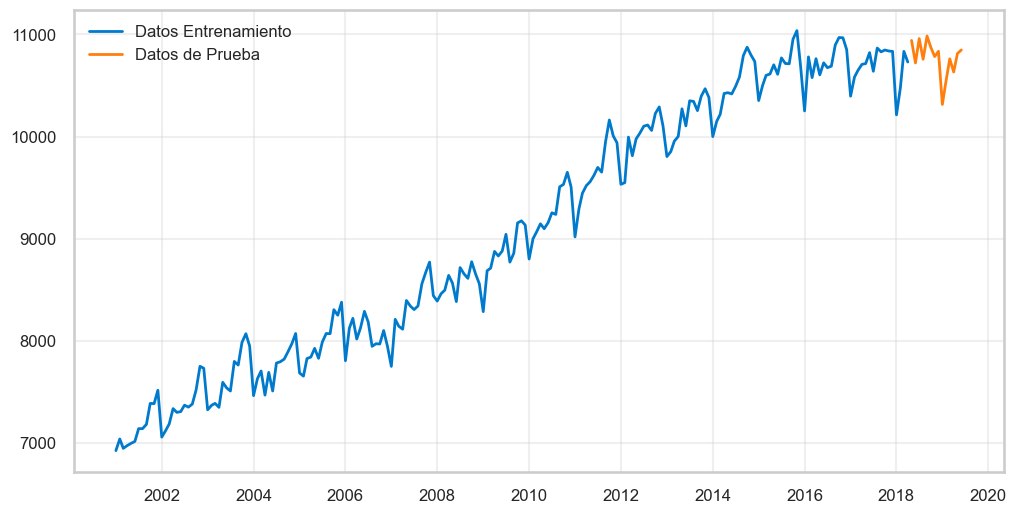

In [224]:
train_len = 208
train_to = data[["Ocupados"]][:train_len]
test_to = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(test_to,label="Datos de Prueba")
plt.legend(loc= "upper left")
plt.show()

## **Tendencia Lineal** ##

In [225]:
y = train_to["Ocupados"] ##Establecer la variable dependiente
x = np.linspace(1,train_len,train_len) ##Crear variable independiente con los meses de entrenamiento
X = sm.add_constant(x) ##Añadir constante al modelo
lin = sm.OLS(y,X) ##Definir el modelo de regresión lineal
lin_t = lin.fit() ##Ajustar el modelo
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     5349.
Date:               lun, 03 nov. 2025   Prob (F-statistic):          2.40e-149
Time:                        13:44:56   Log-Likelihood:                -1437.9
No. Observations:                 208   AIC:                             2880.
Df Residuals:                     206   BIC:                             2886.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6895.5480     34.015    202.723      0.0

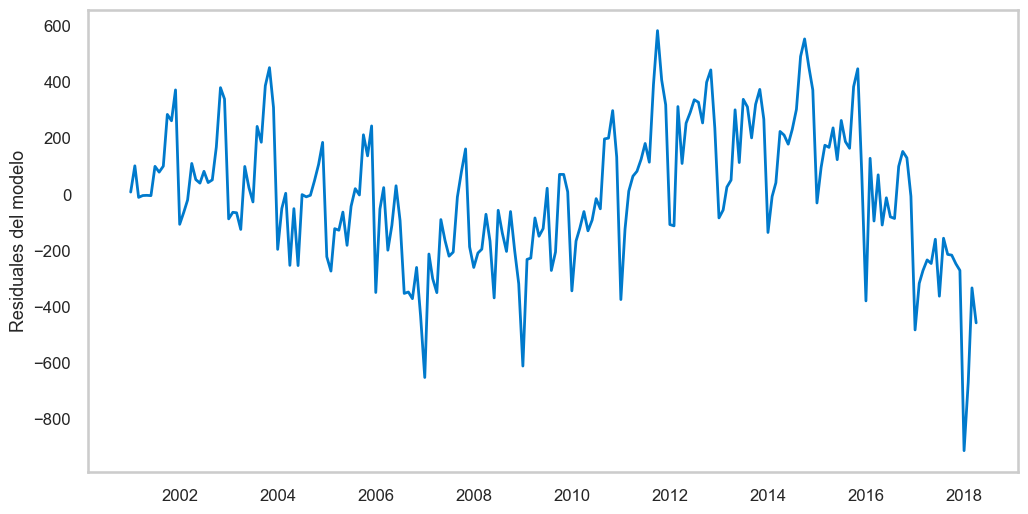

In [226]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

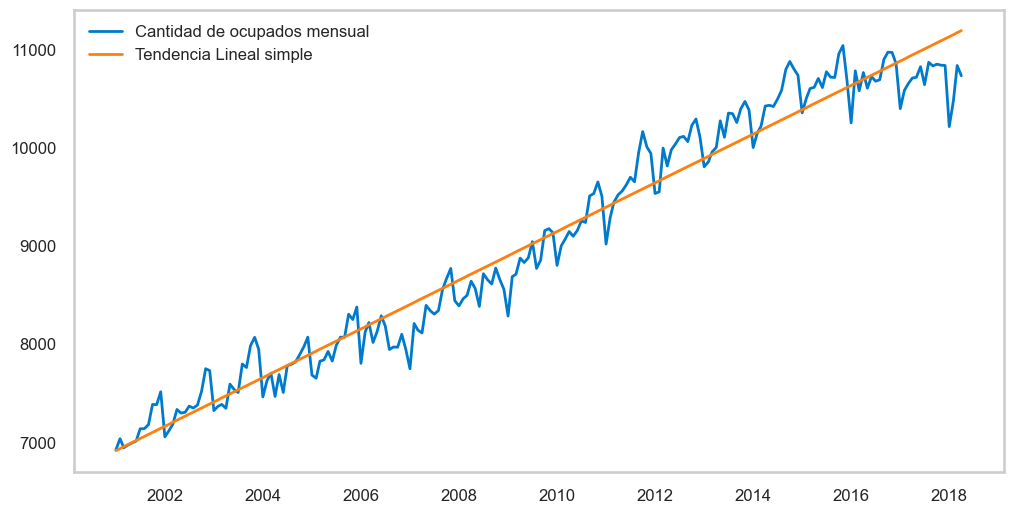

In [227]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal simple")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [228]:
h=14 #Coloco 14 porque el horizonte de predicción es de 14 meses (test)
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [229]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

    Point_forecast      lower_95      upper_95
0     11498.491470  11011.009848  11985.973092
1     11519.132472  11031.575276  12006.689668
2     11539.773474  11052.140081  12027.406867
3     11560.414476  11072.704264  12048.124689
4     11581.055478  11093.267823  12068.843133
5     11601.696481  11113.830761  12089.562200
6     11622.337483  11134.393076  12110.281889
7     11642.978485  11154.954770  12131.002200
8     11663.619487  11175.515842  12151.723132
9     11684.260489  11196.076293  12172.444686
10    11704.901491  11216.636123  12193.166860
11    11725.542493  11237.195333  12213.889654
12    11746.183496  11257.753922  12234.613069
13    11766.824498  11278.311892  12255.337104


In [230]:
# Fechas de pronóstico
future_dates = pd.date_range(
    train_to.index[-1] + pd.offsets.MonthBegin(1),  # mes siguiente al último
    periods=h,
    freq='MS'
)


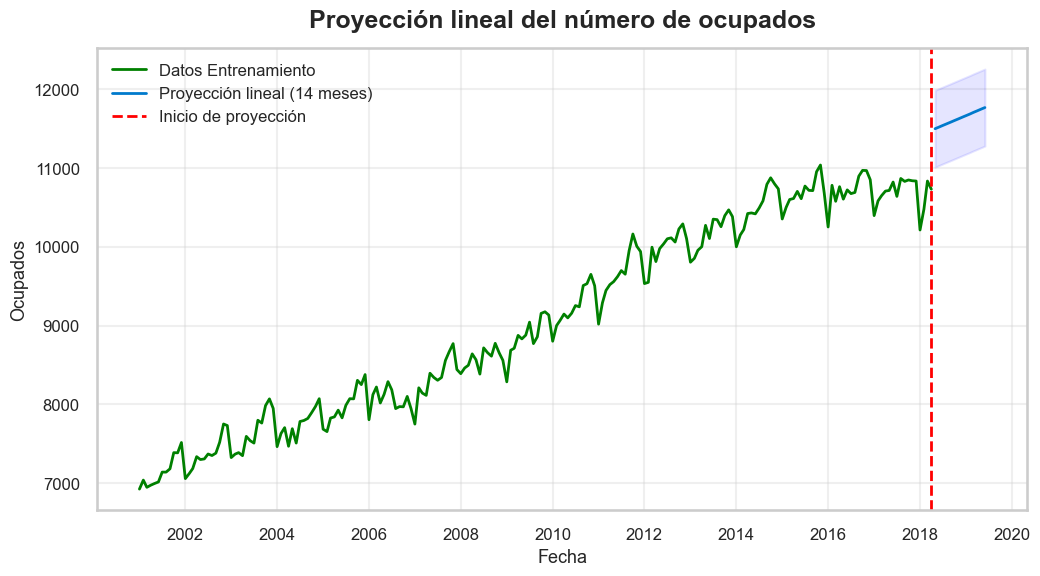

In [231]:
plt.figure(figsize=(12,6))
plt.plot(train_to.index, train_to["Ocupados"], label="Datos Entrenamiento", color="green")
plt.plot(future_dates, preds['Point_forecast'], label="Proyección lineal (14 meses)")

# Línea de inicio de proyección (en fecha, no en índice numérico)
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')


# Intervalos de confianza
plt.fill_between(future_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.title("Proyección lineal del número de ocupados")
plt.xlabel("Fecha")
plt.ylabel("Ocupados")
plt.grid(alpha=0.3)
plt.show()

In [232]:
rmse = np.sqrt(mean_squared_error(test_to, y_prd))
print("RMSE del modelo lineal:", round(rmse, 2))

RMSE del modelo lineal: 888.91


### **Tendencia Cuadratica**

In [233]:
y = train_to["Ocupados"]
train_to["x"] = np.linspace(1, train_len, train_len)
train_to["x2"] = train_to["x"] ** 2
X = sm.add_constant(train_to[["x", "x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2665.
Date:               lun, 03 nov. 2025   Prob (F-statistic):          1.91e-147
Time:                        13:44:57   Log-Likelihood:                -1437.7
No. Observations:                 208   AIC:                             2881.
Df Residuals:                     205   BIC:                             2891.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6875.0373     51.420    133.702      0.0

En este modelo, se observa un x de 21.22, que significa que por cada mes aumentan en 21 personas los ocupados, el r2 nuevamente muestra que hay una tendencia positiva, incluso mejora el resultado anterior, con 96%, hay una tendencia cuadrática en el modelo.
Sin embargo el p de 0.595, nos muestra que no es estadisticamente significativo, el Durbin-Watson: 0.594, continua con autocorrelción positiva en los residuos (estos modelos aún no aplican estacionalidad)

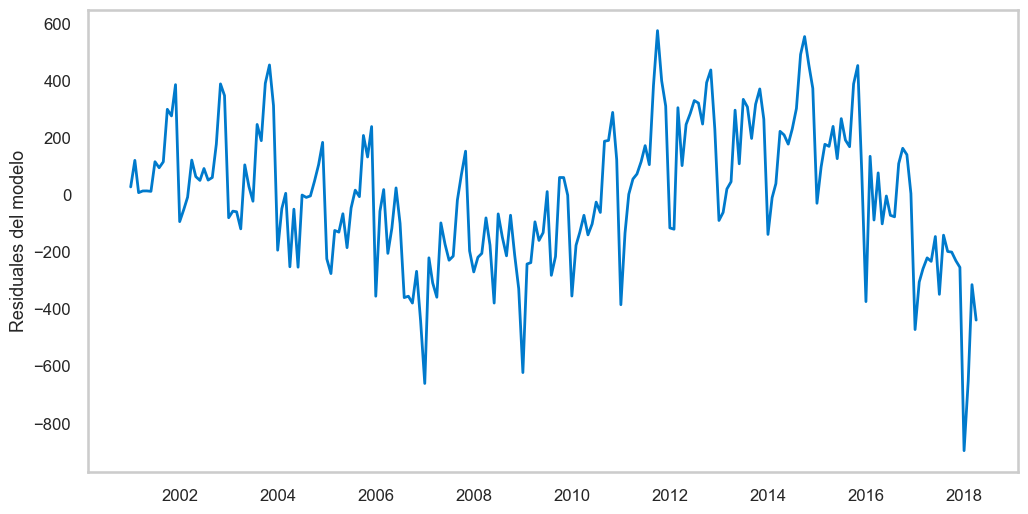

In [234]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

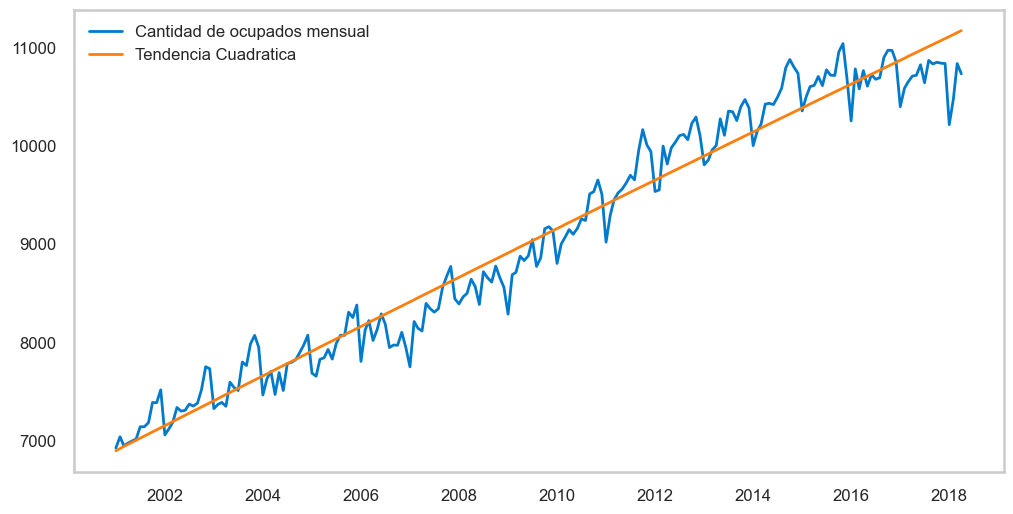

In [235]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [236]:
h = 14
x_for = np.linspace(train_to.shape[0] + 1, train_to.shape[0] + h, h)
X_for = sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [237]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame({
    'Point_forecast': y_prd,
    'lower_95': yprd_ci_lower,
    'upper_95': yprd_ci_upper
})

print(preds)

    Point_forecast      lower_95      upper_95
0     11189.006699  10695.776416  11682.236983
1     11209.058876  10715.422261  11702.695492
2     11229.105446  10735.049213  11723.161678
3     11249.146407  10754.657029  11743.635786
4     11269.181760  10774.245464  11764.118057
5     11289.211506  10793.814274  11784.608739
6     11309.235644  10813.363213  11805.108074
7     11329.254174  10832.892038  11825.616310
8     11349.267096  10852.400500  11846.133691
9     11369.274410  10871.888355  11866.660465
10    11389.276116  10891.355355  11887.196877
11    11409.272215  10910.801255  11907.743175
12    11429.262705  10930.225807  11928.299604
13    11449.247588  10949.628765  11948.866412


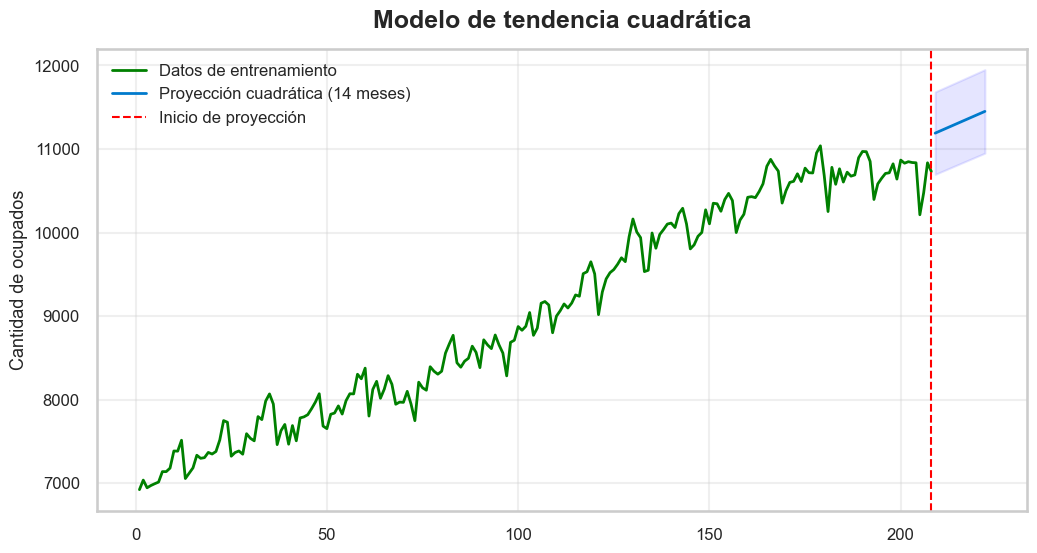

In [238]:
fig = plt.figure(figsize=(12, 6))

# Eje X numérico para entrenamiento
x = np.arange(1, train_to.shape[0] + 1)
y = train_to["Ocupados"].values

# Serie real (entrenamiento)
plt.plot(x, y, label="Datos de entrenamiento", color="green")

# Predicción futura
x_future = np.arange(train_to.shape[0] + 1, train_to.shape[0] + 1 + len(preds))
plt.plot(x_future,preds['Point_forecast'],label="Proyección cuadrática (14 meses)")

# Intervalo de confianza
plt.fill_between(x_future,preds['lower_95'],preds['upper_95'],color='blue',alpha=0.1)

# Línea divisoria del inicio de proyección
plt.axvline(x=train_to.shape[0], color='red',linestyle='--',linewidth=1.5,label='Inicio de proyección')

# Detalles del gráfico
plt.title("Modelo de tendencia cuadrática")
plt.ylabel("Cantidad de ocupados")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


In [239]:
rmse_quad = np.sqrt(mean_squared_error(test_to["Ocupados"], y_prd))
print("RMSE del modelo de tendencia cuadrática:", round(rmse_quad, 2))

RMSE del modelo de tendencia cuadrática: 589.06


## **Revisión de la tendencia de manera polinómica** ##

In [240]:
# Variables
y_train = train_to["Ocupados"]
y_test = test_to["Ocupados"]

# Crear variable de tiempo para ambos conjuntos
train_to["x"] = np.linspace(1, train_to.shape[0], train_to.shape[0])
test_to["x"] = np.linspace(train_to.shape[0]+1, train_to.shape[0]+test_to.shape[0], test_to.shape[0])

# Rango de grados polinómicos a probar
grados = [2, 3, 4, 5, 6, 7, 8, 9, 10]

resultados = {}

for g in grados:
    # Crear variable x^g en ambos conjuntos
    train_to[f"x{g}"] = train_to["x"] ** g
    test_to[f"x{g}"] = test_to["x"] ** g

    # Definir las variables predictoras y añadir constante
    X_train = sm.add_constant(train_to[["x", f"x{g}"]])
    X_test = sm.add_constant(test_to[["x", f"x{g}"]])

    # Entrenar modelo en train
    modelo = sm.OLS(y_train, X_train).fit()

    # Predecir sobre test
    y_pred_test = modelo.predict(X_test)

    # Calcular RMSE en test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Guardar resultados
    resultados[g] = {
        "R² (train)": round(modelo.rsquared_adj, 4),
        "RMSE (test)": round(rmse, 2)
    }

# Mostrar tabla resumen
tabla_resultados = pd.DataFrame(resultados).T
tabla_resultados.index.name = "Grado del polinomio"
print(tabla_resultados)



                     R² (train)  RMSE (test)
Grado del polinomio                         
2                        0.9626       589.06
3                        0.9632       511.55
4                        0.9642       424.20
5                        0.9654       336.80
6                        0.9664       256.22
7                       -4.5481      4899.78
8                      -36.4369     16172.18
9                      -37.8056     17481.59
10                     -38.9498     18827.05


Pareciera que el mejor modelo, el que mejor captura la tendencia es el del grado 6, sin embargo, podría haber overfitting y pierde interpretabilidad

## **Estacionalidad** ##

A partir de acá, el objetivo es capturar la estacionalidad de los modelos, inicialmente generando un numero por cad mes desde el índice de fechas

In [241]:
# Asegurar índice datetime y frecuencia mensual, para crear dummies de meses
train_to.index = pd.to_datetime(train_to.index)
train_to = train_to.asfreq('MS')

In [242]:
# Crear las dummies mensuales (todas numéricas)
month_dummies = pd.get_dummies(train_to.index.month, prefix='mes', drop_first=True)
month_dummies.index = train_to.index
# Convertir a float explícitamente ( evita el error de casteo)
month_dummies = month_dummies.astype(float)

In [243]:
train_to.index.month.value_counts()

mes
1     18
2     18
3     18
4     18
5     17
6     17
7     17
8     17
9     17
10    17
11    17
12    17
Name: count, dtype: int64

In [244]:
# Definir las variables
y = train_to["Ocupados"].astype(float)
X = sm.add_constant(month_dummies)

# Ajustar modelo OLS
sea = sm.OLS(y, X)
season = sea.fit()

# Resultado
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.2730
Date:               lun, 03 nov. 2025   Prob (F-statistic):              0.990
Time:                        13:44:58   Log-Likelihood:                -1778.9
No. Observations:                 208   AIC:                             3582.
Df Residuals:                     196   BIC:                             3622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    304.347     28.666      0.0

In [245]:
month_dummies


,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
mes,,,,,,,,,,,
2001-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


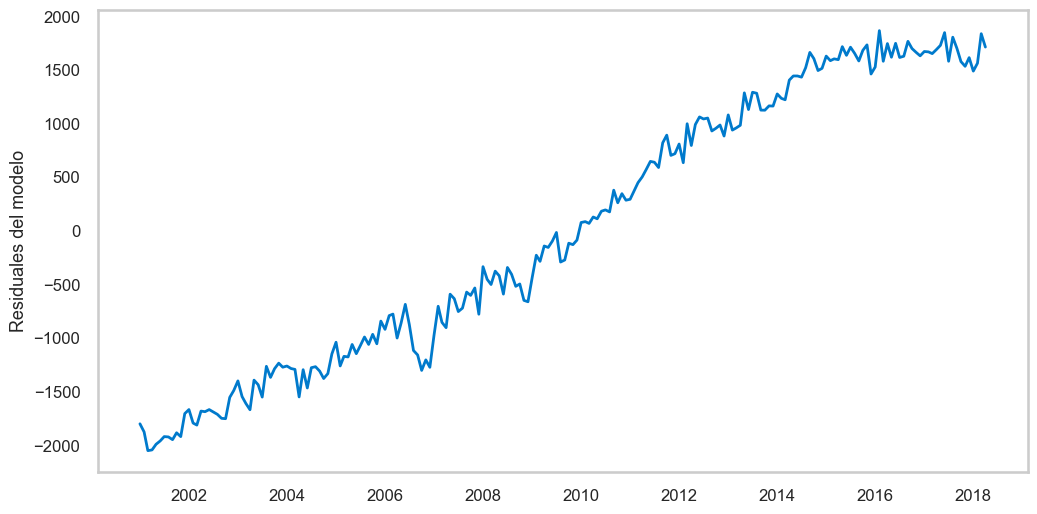

In [246]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

El modelo con solo dummies mensuales para capturar la estacionalidad no es syficiente, subestima en los primeros años y sobreestima en los finales
El componente estacional existe pero no es suficiente.
hay que agregar un término que capture la tendencia de largo plazo.

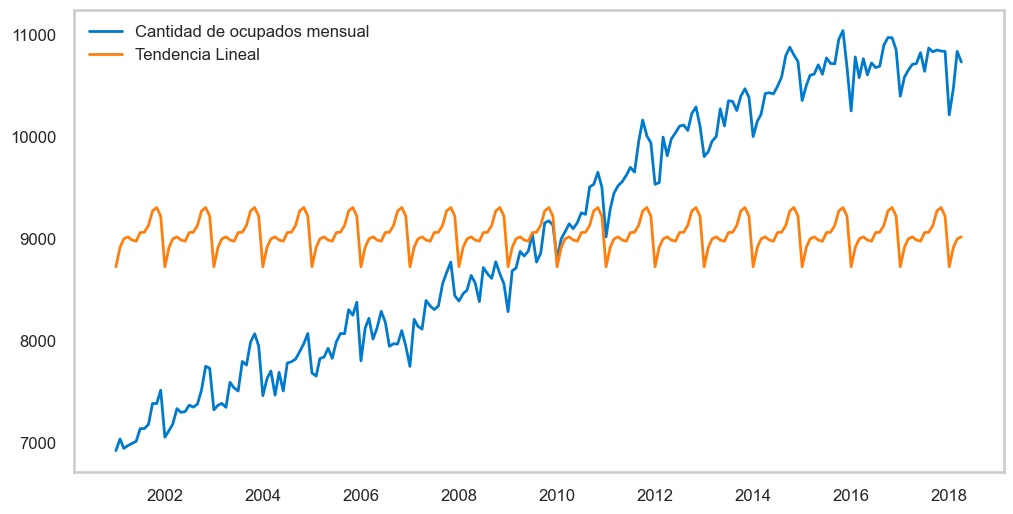

In [247]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [248]:
range_dates = pd.date_range(train_to.index[-1]+ relativedelta(months=1), periods=14,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True).astype(int)
X_for= sm.add_constant(x_for)

In [249]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2018-05-01     8986.488706  6366.161248  11606.816164
2018-06-01     8974.779765  6354.452307  11595.107223
2018-07-01     9059.390353  6439.062895  11679.717811
2018-08-01     9062.507118  6442.179660  11682.834576
2018-09-01     9129.933235  6509.605777  11750.260693
2018-10-01     9270.852412  6650.524954  11891.179870
2018-11-01     9304.549471  6684.222013  11924.876929
2018-12-01     9220.622941  6600.295483  11840.950399
2019-01-01     8724.538722  6108.258104  11340.819340
2019-02-01     8914.544389  6298.263771  11530.825007
2019-03-01     8997.218333  6380.937715  11613.498951
2019-04-01     9017.681722  6401.401104  11633.962340
2019-05-01     8986.488706  6366.161248  11606.816164
2019-06-01     8974.779765  6354.452307  11595.107223


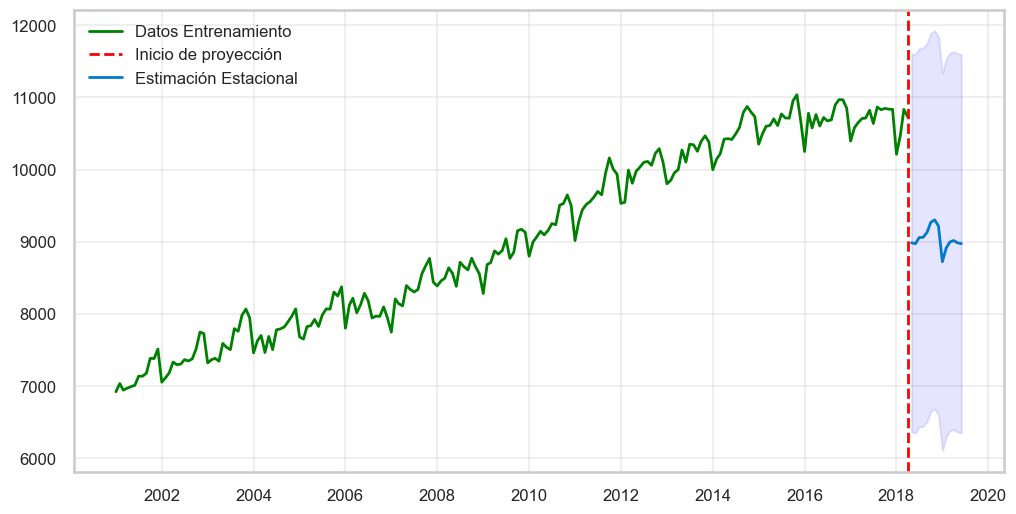

In [250]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to.index, train_to["Ocupados"], label="Datos Entrenamiento", color="green")
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc= "upper left")
plt.show()

In [251]:
# Predicciones dentro del conjunto de entrenamiento
dt_train = season.get_prediction().summary_frame(alpha=0.05)
y_pred_train = dt_train['mean']

# Cálculo del RMSE (comparando con los valores reales)
rmse = np.sqrt(mean_squared_error(train_to["Ocupados"], y_pred_train))

print(f"RMSE del modelo lineal estacional: {rmse:.2f}")

RMSE del modelo lineal estacional: 1253.44


### **Tendencia + Estacionalidad**

In [252]:
y = train_to["Ocupados"]
train_to["x"] = np.linspace(1,train_to.shape[0],train_to.shape[0])
train_to["x2"] = train_to["x"]**2

month_dummies = pd.get_dummies(train_to.index.month,drop_first=True).set_index(train_to.index).astype(int)
X = sm.add_constant( pd.concat([train_to[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     553.6
Date:               lun, 03 nov. 2025   Prob (F-statistic):          1.37e-145
Time:                        13:44:59   Log-Likelihood:                -1401.9
No. Observations:                 208   AIC:                             2832.
Df Residuals:                     194   BIC:                             2879.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6595.9008     64.522    102.227      0.0

Este modelo sí se ajusta mejor, tiene un r2 de 97%, lo cual es muy bueno, con un crecimiento segun e lmodelo de 20 por mes, ell componente cuadrático no aporta mucho.

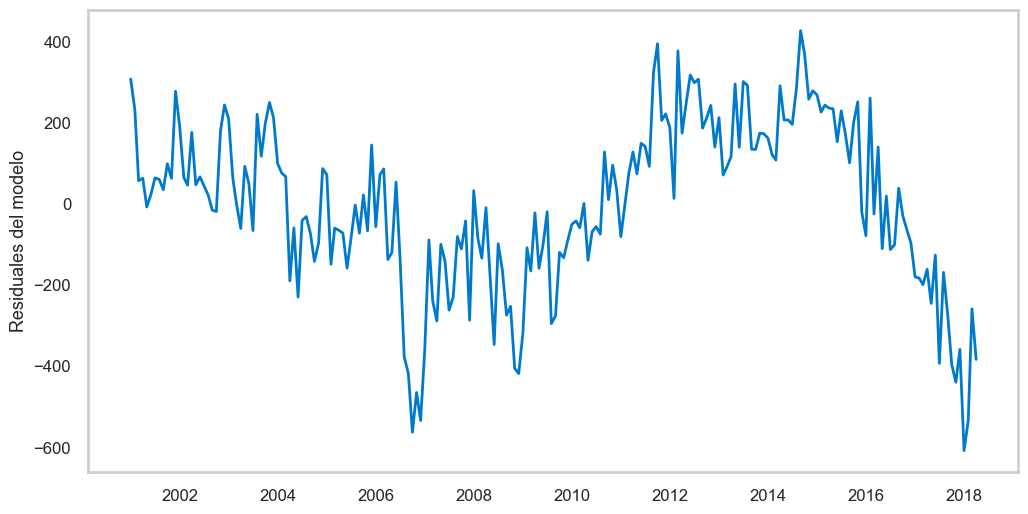

In [253]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

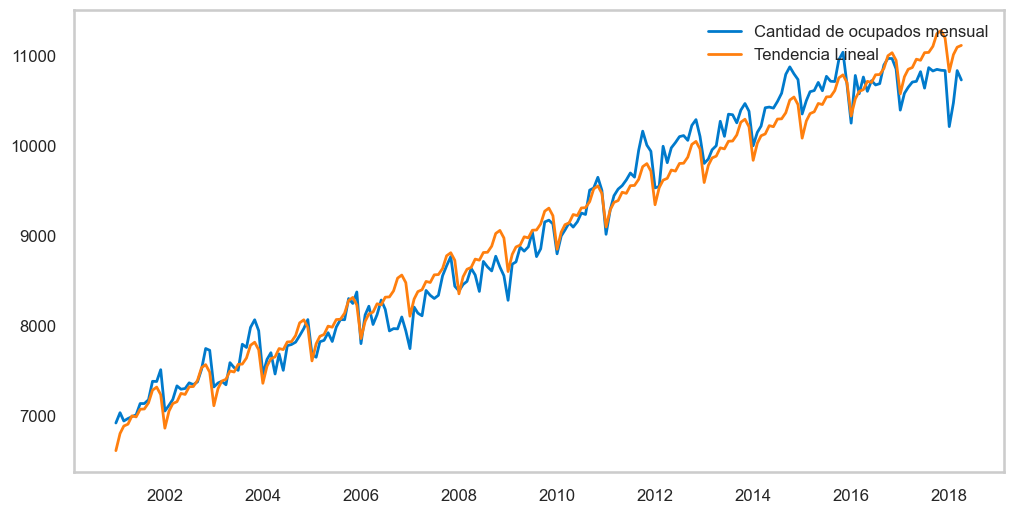

In [254]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [255]:
h=14
x_for= np.linspace((train_to.shape[0]+1),(train_to.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(train_to.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,209.0,43681.0,False,False,False,True,False,False,False,False,False,False,False
1,1.0,210.0,44100.0,False,False,False,False,True,False,False,False,False,False,False
2,1.0,211.0,44521.0,False,False,False,False,False,True,False,False,False,False,False
3,1.0,212.0,44944.0,False,False,False,False,False,False,True,False,False,False,False
4,1.0,213.0,45369.0,False,False,False,False,False,False,False,True,False,False,False
5,1.0,214.0,45796.0,False,False,False,False,False,False,False,False,True,False,False
6,1.0,215.0,46225.0,False,False,False,False,False,False,False,False,False,True,False
7,1.0,216.0,46656.0,False,False,False,False,False,False,False,False,False,False,True
8,1.0,217.0,47089.0,False,False,False,False,False,False,False,False,False,False,False
9,1.0,218.0,47524.0,True,False,False,False,False,False,False,False,False,False,False


In [256]:
dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    11205.425474  10767.112917  11643.738030
2018-06-01    11193.526779  10754.912369  11632.141189
2018-07-01    11277.947614  10839.022943  11716.872285
2018-08-01    11280.874626  10841.631303  11720.117948
2018-09-01    11348.110990  10908.540644  11787.681336
2018-10-01    11488.840413  11048.934692  11928.746135
2018-11-01    11522.347719  11082.098287  11962.597151
2018-12-01    11438.231436  10997.629980  11878.832893
2019-01-01    11065.948575  10625.946282  11505.950867
2019-02-01    11255.753946  10815.378361  11696.129531
2019-03-01    11338.227596  10897.469475  11778.985716
2019-04-01    11358.490689  10917.340814  11799.640565
2019-05-01    11450.371643  11007.055407  11893.687878
2019-06-01    11438.451865  10994.687242  11882.216487


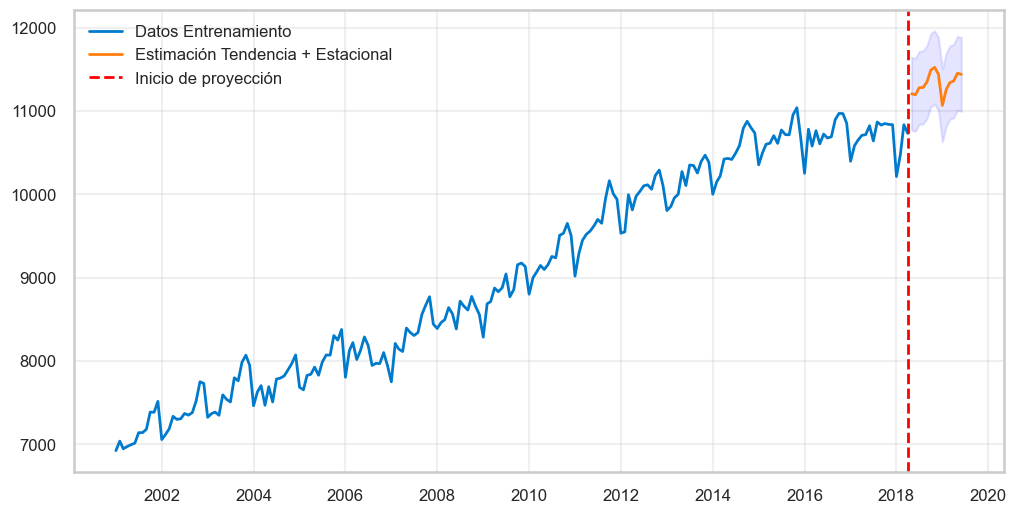

In [257]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

In [258]:
y_true = train_to["Ocupados"]
y_pred = season_pol_2.fittedvalues

# cálculo del RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE del modelo tendencia + estacionalidad: {rmse:.2f}")

RMSE del modelo tendencia + estacionalidad: 204.62


### **Comparación de modelos**

Para realizar la comparación de los modelos se debe usar una metrica de desempeño, en la clase anterior usamos el RMSE, la comparación se debe hacer fuera de muestra.
A continuación se muestra tabla con los datos obtenidos de los ejercicios anteriores, dado que de este ejercicio se obtiene como mejor métrica el modelo con tendencia y estacionaidad, es el que se usará para la predicción de los 6 meses siguientes

| Modelo                                      | Descripción                                    |     RMSE    | Interpretación                                                                                     |
| :------------------------------------------ | :--------------------------------------------- | :---------: | :------------------------------------------------------------------------------------------------- |
| **Lineal simple**                           | Tendencia lineal sin estacionalidad            |  **888.91** | Captura la tendencia general, pero deja mucha variabilidad sin explicar.                           |
| **Tendencia cuadrática**                    | Tendencia con término ( x^2 )                  |  **589.06** | Mejora considerablemente la precisión al permitir curvatura en la tendencia.                       |
| **Lineal estacional**                       | Solo estacionalidad (sin tendencia)            | **1253.44** | La estacionalidad por sí sola no explica bien el comportamiento global.                            |
| **Tendencia + estacionalidad (cuadrática)** | Modelo completo con tendencia y estacionalidad |  **204.62** | Es el modelo más preciso: combina tendencia y estacionalidad, ajustando mejor los patrones reales. |


## **Proyección de 6 meses siguientes** ##

In [259]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = data["x"]**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     502.6
Date:               lun, 03 nov. 2025   Prob (F-statistic):          3.33e-149
Time:                        13:45:00   Log-Likelihood:                -1519.4
No. Observations:                 222   AIC:                             3067.
Df Residuals:                     208   BIC:                             3114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6508.3401     69.460     93.700      0.0

In [260]:
h=14
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,223.0,49729.0,False,False,False,False,False,True,False,False,False,False,False
1,1.0,224.0,50176.0,False,False,False,False,False,False,True,False,False,False,False
2,1.0,225.0,50625.0,False,False,False,False,False,False,False,True,False,False,False
3,1.0,226.0,51076.0,False,False,False,False,False,False,False,False,True,False,False
4,1.0,227.0,51529.0,False,False,False,False,False,False,False,False,False,True,False
5,1.0,228.0,51984.0,False,False,False,False,False,False,False,False,False,False,True
6,1.0,229.0,52441.0,False,False,False,False,False,False,False,False,False,False,False
7,1.0,230.0,52900.0,True,False,False,False,False,False,False,False,False,False,False
8,1.0,231.0,53361.0,False,True,False,False,False,False,False,False,False,False,False
9,1.0,232.0,53824.0,False,False,True,False,False,False,False,False,False,False,False


In [261]:
dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
preds = preds.iloc[:6]
print(preds)



            Point_forecast      lower_95      upper_95
2019-07-01    11522.851616  11078.628550  11967.074682
2019-08-01    11525.757544  11081.066008  11970.449080
2019-09-01    11592.972825  11147.802825  12038.142824
2019-10-01    11733.681164  11288.022739  12179.339589
2019-11-01    11767.167386  11321.010606  12213.324166
2019-12-01    11683.030020  11236.364989  12129.695051


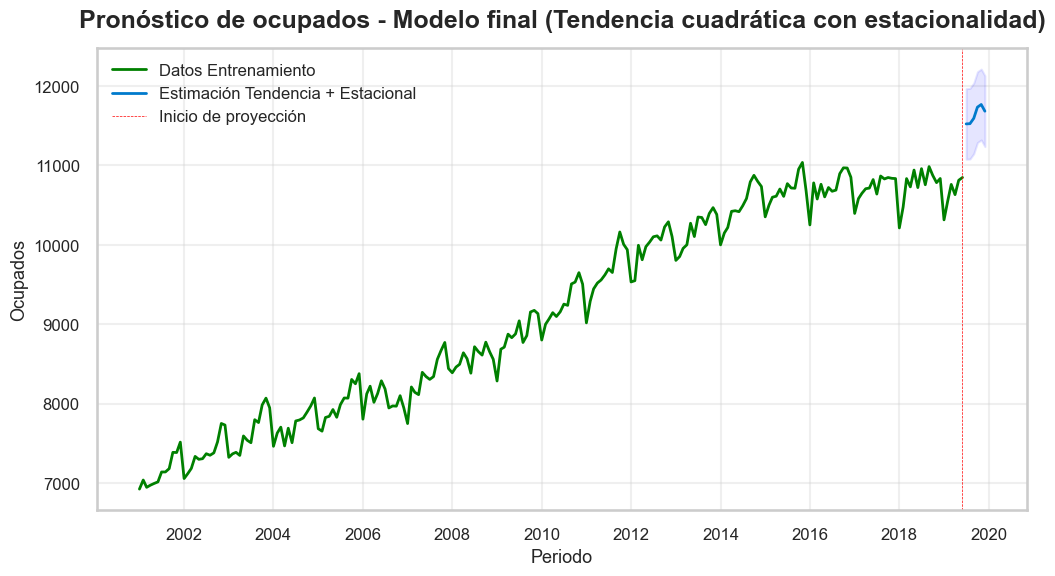

In [262]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento", color="green")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.axvline(data.index[-1], color='red', linestyle='--', label='Inicio de proyección', linewidth=0.5)
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.title("Pronóstico de ocupados - Modelo final (Tendencia cuadrática con estacionalidad)")
plt.xlabel("Periodo")
plt.ylabel("Ocupados")
plt.legend(loc="upper left")
plt.show()